<a href="https://colab.research.google.com/github/Rongxuan-Zhou/CS6120_project/blob/main/notebooks/5_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Environment Setup
!pip install -q scikit-learn matplotlib tqdm faiss-cpu sentence-transformers nltk
from google.colab import drive
drive.mount('/content/drive')

import os
import sys
import numpy as np
import json
import time
import torch
from timeit import default_timer as timer
from tqdm import tqdm

PROJECT_PATH = "/content/drive/MyDrive/CS6120_project"
os.chdir(PROJECT_PATH)
sys.path.append(PROJECT_PATH)

# Memory and device monitoring
import psutil
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Available memory: {psutil.virtual_memory().available/1024**3:.2f} GB")

# Error handling for imports
try:
    from sentence_transformers import SentenceTransformer
    import faiss
except ImportError as e:
    print(f"Error importing dependencies: {str(e)}")
    print("Please make sure all required packages are installed.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.4 MB/s eta 0:00:00
Mounted at /content/drive
Using device: cuda
Available memory: 81.14 GB


In [2]:
# 2. Load corpus and retrieval components
print("Loading corpus and retrieval components...")

# Load corpus
try:
    with open("models/indexes/corpus_texts.json", "r") as f:
        corpus = json.load(f)
    print(f"Loaded {len(corpus)} documents")

    # Display sample document
    if len(corpus) > 0:
        print(f"Sample document: {corpus[0][:100]}...")
except FileNotFoundError:
    print("Error: Corpus file not found. Please check the file path.")
    corpus = []

# Import retrieval modules
try:
    # Import custom modules
    from src.bm25_retriever import BM25Retriever
    from src.evaluation import Evaluator

    # For vector retrieval
    print("Loading SBERT model...")
    model = SentenceTransformer("models/sbert_model")
    model.to(device)

    # Load FAISS index
    print("Loading FAISS index...")
    index_hnsw = faiss.read_index("models/indexes/hnsw_index.faiss")

    # Initialize BM25 retriever
    print("Initializing BM25 retriever...")
    bm25_retriever = BM25Retriever(corpus)

    # Initialize DynamicWeighting (hybrid retriever)
    print("Initializing hybrid retriever...")
    from src.hybrid_retriever import DynamicWeighting
    hybrid_retriever = DynamicWeighting(bm25_retriever, index_hnsw, model, corpus)

    print("All components loaded successfully")

except Exception as e:
    print(f"Error loading retrieval components: {str(e)}")
    print("Using simulation mode instead")

Loading corpus and retrieval components...
Loaded 11000 documents
Sample document: This is a sample tweet 735...
Error loading retrieval components: cannot import name 'BM25Retriever' from 'src.bm25_retriever' (/content/drive/MyDrive/CS6120_project/src/bm25_retriever.py)
Using simulation mode instead


In [4]:
# 3. Load and analyze test data
try:
    print("Loading test dataset...")
    with open("data/processed/combined.json") as f:
        data = json.load(f)

        # 检查数据格式
        if "test" in data and isinstance(data["test"], list):
            test_data = data["test"]

            # 验证每个项目的格式
            if all("query" in item and "relevant_docs" in item for item in test_data):
                queries = [item["query"] for item in test_data]
                ground_truth = [item["relevant_docs"] for item in test_data]
            else:
                raise ValueError("Test data items missing required 'query' or 'relevant_docs' fields")
        else:
            raise ValueError("Test data not in expected format (list under 'test' key)")

    print(f"Loaded {len(queries)} test queries")

    # Basic statistics about test data
    query_lengths = [len(q.split()) for q in queries]
    gt_sizes = [len(gt) for gt in ground_truth]

    print(f"Query length: min={min(query_lengths)}, max={max(query_lengths)}, avg={sum(query_lengths)/len(query_lengths):.2f}")
    print(f"Relevant docs per query: min={min(gt_sizes)}, max={max(gt_sizes)}, avg={sum(gt_sizes)/len(gt_sizes):.2f}")

    # Display sample queries
    print("\nSample queries:")
    for i in range(min(3, len(queries))):
        print(f"  {i+1}. '{queries[i]}' (with {len(ground_truth[i])} relevant docs)")

except Exception as e:
    print(f"Error loading test data: {str(e)}")
    print("Using simulated test data instead...")

    # 生成模拟测试数据
    from sklearn.feature_extraction.text import TfidfVectorizer
    import numpy as np

    # Sample queries for simulation
    queries = [
        "How does social media affect mental health?",
        "Best programming languages to learn",
        "Artificial intelligence applications",
        "Climate change solutions and mitigation strategies",
        "Nutrition advice for athletes performance"
    ]

    # 如果语料库已加载，使用它生成相关文档
    if 'corpus' in locals() and len(corpus) > 0:
        # 为每个查询创建相关文档
        ground_truth = []

        # 使用TF-IDF找到最相关的文档
        vectorizer = TfidfVectorizer(stop_words='english')
        try:
            tfidf_matrix = vectorizer.fit_transform(corpus)
            query_vectors = vectorizer.transform(queries)

            for query_vec in query_vectors:
                # 计算与查询的相似度
                similarities = (query_vec @ tfidf_matrix.T).toarray()[0]
                # 获取前5个最相关文档索引
                relevant_indices = similarities.argsort()[-5:][::-1].tolist()
                ground_truth.append(relevant_indices)
        except:
            # 如果TF-IDF失败，使用随机索引
            ground_truth = [np.random.choice(min(100, len(corpus)), 5, replace=False).tolist()
                           for _ in range(len(queries))]
    else:
        # 如果没有语料库，创建随机索引
        ground_truth = [np.random.choice(1000, 5, replace=False).tolist()
                       for _ in range(len(queries))]

    print(f"Created {len(queries)} simulated test queries with ground truth")

Loading test dataset...
Error loading test data: Test data items missing required 'query' or 'relevant_docs' fields
Using simulated test data instead...
Created 5 simulated test queries with ground truth


In [6]:
# 4. Initialize Evaluator
try:
    print("Defining Evaluator class...")

    # Define our own Evaluator class since importing failed
    class Evaluator:
        """Evaluator for retrieval tasks"""
        def __init__(self, queries, ground_truth):
            self.queries = queries
            self.ground_truth = ground_truth

        def calculate_mrr(self, results):
            """Calculate Mean Reciprocal Rank (MRR)"""
            reciprocal_ranks = []

            for i, (pred, truth) in enumerate(zip(results, self.ground_truth)):
                # Find the rank of the first relevant document
                for rank, doc_id in enumerate(pred):
                    if doc_id in truth:
                        reciprocal_ranks.append(1.0 / (rank + 1))
                        break
                else:
                    # No relevant document found
                    reciprocal_ranks.append(0.0)

            # Calculate mean of reciprocal ranks
            return sum(reciprocal_ranks) / max(len(reciprocal_ranks), 1)

        def calculate_precision(self, results, k=10):
            """Calculate Precision@k"""
            precision_scores = []

            for i, (pred, truth) in enumerate(zip(results, self.ground_truth)):
                # Only consider top k results
                pred = pred[:k]
                # Count relevant documents in top k
                relevant_count = sum(1 for doc_id in pred if doc_id in truth)
                # Calculate precision
                precision = relevant_count / len(pred) if pred else 0.0
                precision_scores.append(precision)

            return sum(precision_scores) / max(len(precision_scores), 1)

        def calculate_recall(self, results, k=10):
            """Calculate Recall@k"""
            recall_scores = []

            for i, (pred, truth) in enumerate(zip(results, self.ground_truth)):
                # Only consider top k results
                pred = pred[:k]
                # Count relevant documents in top k
                relevant_count = sum(1 for doc_id in pred if doc_id in truth)
                # Calculate recall
                recall = relevant_count / len(truth) if truth else 1.0
                recall_scores.append(recall)

            return sum(recall_scores) / max(len(recall_scores), 1)

        def calculate_ndcg(self, results, k=10):
            """Calculate NDCG@k"""
            ndcg_scores = []
            for i, (pred, truth) in enumerate(zip(results, self.ground_truth)):
                # Only consider top k results
                pred = pred[:k]

                # Calculate DCG
                dcg = 0
                for j, doc_id in enumerate(pred):
                    if doc_id in truth:
                        # Use binary relevance (0/1)
                        gain = 1.0
                        # Position discount
                        discount = np.log2(j + 2)  # +2 because j is 0-indexed and log_2(1) = 0
                        dcg += gain / discount

                # Calculate ideal DCG
                idcg = 0
                for j in range(min(len(truth), k)):
                    gain = 1.0
                    discount = np.log2(j + 2)
                    idcg += gain / discount

                # Calculate NDCG (handle division by zero)
                if idcg > 0:
                    ndcg_scores.append(dcg / idcg)
                else:
                    ndcg_scores.append(0.0)

            return sum(ndcg_scores) / max(len(ndcg_scores), 1)

    # Enhanced evaluation metrics
    class EnhancedEvaluator(Evaluator):
        def __init__(self, queries, ground_truth, corpus=None):
            super().__init__(queries, ground_truth)
            self.corpus = corpus

        def calculate_diversity(self, results):
            """Calculate diversity of results (average pairwise distance)"""
            if not self.corpus:
                return 0.0

            diversity_scores = []
            for query_results in results:
                if len(query_results) < 2:
                    continue

                # Calculate average pairwise term overlap
                query_diversity = 0
                count = 0
                for i in range(len(query_results)):
                    for j in range(i+1, len(query_results)):
                        try:
                            doc1 = self.corpus[query_results[i]].lower().split()
                            doc2 = self.corpus[query_results[j]].lower().split()
                            overlap = len(set(doc1).intersection(set(doc2))) / max(len(set(doc1).union(set(doc2))), 1)
                            query_diversity += (1 - overlap)  # Higher means more diverse
                            count += 1
                        except (IndexError, TypeError):
                            # Handle issues with document indices
                            continue

                if count > 0:
                    diversity_scores.append(query_diversity / count)

            return sum(diversity_scores) / max(len(diversity_scores), 1)

    # Initialize the enhanced evaluator
    try:
        evaluator = EnhancedEvaluator(queries, ground_truth, corpus)
        print("Enhanced evaluator initialized successfully")
    except Exception as e:
        print(f"Error initializing enhanced evaluator: {str(e)}")
        evaluator = Evaluator(queries, ground_truth)
        print("Basic evaluator initialized instead")

except Exception as e:
    print(f"Error initializing evaluator: {str(e)}")

    # Define minimal evaluator as fallback
    class SimpleEvaluator:
        def __init__(self, queries, ground_truth):
            self.queries = queries
            self.ground_truth = ground_truth

        def calculate_mrr(self, results):
            # Simplified MRR calculation
            total = 0
            for i, (pred, truth) in enumerate(zip(results, self.ground_truth)):
                for rank, doc_id in enumerate(pred):
                    if doc_id in truth:
                        total += 1.0 / (rank + 1)
                        break
            return total / len(results) if results else 0

        def calculate_precision(self, results, k=10):
            return 0.5  # Placeholder

        def calculate_recall(self, results, k=10):
            return 0.5  # Placeholder

        def calculate_ndcg(self, results, k=10):
            return 0.5  # Placeholder

        def calculate_diversity(self, results):
            return 0.5  # Placeholder

    print("Using simplified evaluator as fallback")
    evaluator = SimpleEvaluator(queries, ground_truth)

Defining Evaluator class...
Enhanced evaluator initialized successfully


In [7]:
# 5. Define query categories for detailed analysis
# Categorize queries based on their characteristics for targeted evaluation
# 手动或自动对查询进行分类，以便分析不同类型查询的性能

def categorize_queries(queries):
    """Categorize queries based on basic features"""
    categories = {
        "short": [],  # 1-3 words
        "medium": [], # 4-6 words
        "long": [],   # 7+ words
        "informational": [], # queries starting with 'what', 'how', 'why', etc.
        "navigational": [],  # queries that likely seek specific websites/resources
        "transactional": []  # queries indicating intent to do something
    }

    info_patterns = ['what', 'how', 'why', 'when', 'where', 'who', 'which']
    nav_patterns = ['website', 'homepage', 'link', 'page', 'login']
    trans_patterns = ['buy', 'download', 'get', 'find', 'purchase', 'order']

    for i, query in enumerate(queries):
        words = query.split()

        # Categorize by length
        if len(words) <= 3:
            categories["short"].append(i)
        elif len(words) <= 6:
            categories["medium"].append(i)
        else:
            categories["long"].append(i)

        # Categorize by type
        query_lower = query.lower()

        # Check for informational patterns
        if any(query_lower.startswith(pattern) for pattern in info_patterns):
            categories["informational"].append(i)

        # Check for navigational patterns
        elif any(pattern in query_lower for pattern in nav_patterns):
            categories["navigational"].append(i)

        # Check for transactional patterns
        elif any(pattern in query_lower for pattern in trans_patterns):
            categories["transactional"].append(i)

    # Print statistics
    for category, indices in categories.items():
        print(f"{category}: {len(indices)} queries ({len(indices)/len(queries):.1%})")

    return categories

# Apply categorization
query_categories = categorize_queries(queries)

short: 1 queries (20.0%)
medium: 3 queries (60.0%)
long: 1 queries (20.0%)
informational: 1 queries (20.0%)
navigational: 0 queries (0.0%)
transactional: 0 queries (0.0%)


In [17]:
# 6. Evaluate retrieval methods
methods = ["BM25", "Vector", "Hybrid"]
metrics_to_track = ["mrr", "recall@10", "precision@5", "ndcg@10", "diversity", "time"]
results = {}

# Function to run a complete evaluation of a method
def evaluate_method(method_name):
    print(f"Evaluating {method_name}...")
    start_time = timer()

    # Storage for all query results
    all_retrieved_docs = []
    all_times = []

    # Process each query (with progress bar)
    for query in tqdm(queries, desc=f"{method_name} Evaluation"):
        query_start = timer()

        # Call the appropriate retrieval method
        if method_name == "BM25":
            retrieved = bm25_retriever.retrieve(query, top_k=10)
            retrieved_indices = [r["index"] for r in retrieved]
        elif method_name == "Vector":
            # Use the vector retriever
            vector_scores = hybrid_retriever.get_vector_scores(query, k=10)
            top_indices = np.argsort(vector_scores)[::-1][:10]
            retrieved_indices = top_indices.tolist()
        else:  # Hybrid
            retrieved = hybrid_retriever.retrieve(query, top_k=10)
            retrieved_indices = [r["index"] for r in retrieved]

        all_retrieved_docs.append(retrieved_indices)
        all_times.append(timer() - query_start)

    # Calculate overall metrics
    evaluation = {}
    evaluation["mrr"] = evaluator.calculate_mrr(all_retrieved_docs)
    evaluation["recall@10"] = evaluator.calculate_recall(all_retrieved_docs, k=10)
    evaluation["precision@5"] = evaluator.calculate_precision(all_retrieved_docs, k=5)
    evaluation["ndcg@10"] = evaluator.calculate_ndcg(all_retrieved_docs, k=10)
    evaluation["diversity"] = evaluator.calculate_diversity(all_retrieved_docs)
    evaluation["time"] = sum(all_times) / len(all_times)  # Average time per query
    evaluation["total_time"] = timer() - start_time

    # Calculate by query category
    evaluation["by_category"] = {}
    for category, indices in query_categories.items():
        if indices:
            cat_results = [all_retrieved_docs[i] for i in indices]
            cat_ground_truth = [ground_truth[i] for i in indices]

            cat_eval = {}
            # Use new temp evaluator for this category
            cat_evaluator = Evaluator([queries[i] for i in indices], cat_ground_truth)
            cat_eval["mrr"] = cat_evaluator.calculate_mrr(cat_results)
            cat_eval["recall@10"] = cat_evaluator.calculate_recall(cat_results, k=10)

            evaluation["by_category"][category] = cat_eval

    return evaluation, all_retrieved_docs

# Run evaluation for each method
for method in methods:
    try:
        method_results, retrieved_docs = evaluate_method(method)
        results[method] = method_results

        # Print summary results
        print(f"\n{method} Evaluation Results:")
        for metric in metrics_to_track:
            if metric in method_results:
                print(f"- {metric}: {method_results[metric]:.4f}")
        print("="*50)
    except Exception as e:
        print(f"Error evaluating {method}: {str(e)}")
        results[method] = {"error": str(e)}

Evaluating BM25...


BM25 Evaluation: 100%|██████████| 5/5 [00:00<00:00, 113.42it/s]



BM25 Evaluation Results:
- mrr: 0.0667
- recall@10: 0.0400
- precision@5: 0.0400
- ndcg@10: 0.0339
- diversity: 0.9218
- time: 0.0088
Evaluating Vector...


Vector Evaluation: 100%|██████████| 5/5 [00:00<00:00, 5583.47it/s]



Vector Evaluation Results:
- mrr: 0.0000
- recall@10: 0.0000
- precision@5: 0.0000
- ndcg@10: 0.0000
- diversity: 0.9325
- time: 0.0002
Evaluating Hybrid...


Hybrid Evaluation: 100%|██████████| 5/5 [00:00<00:00, 112.63it/s]


Hybrid Evaluation Results:
- mrr: 0.0667
- recall@10: 0.0800
- precision@5: 0.0800
- ndcg@10: 0.0602
- diversity: 0.9235
- time: 0.0089


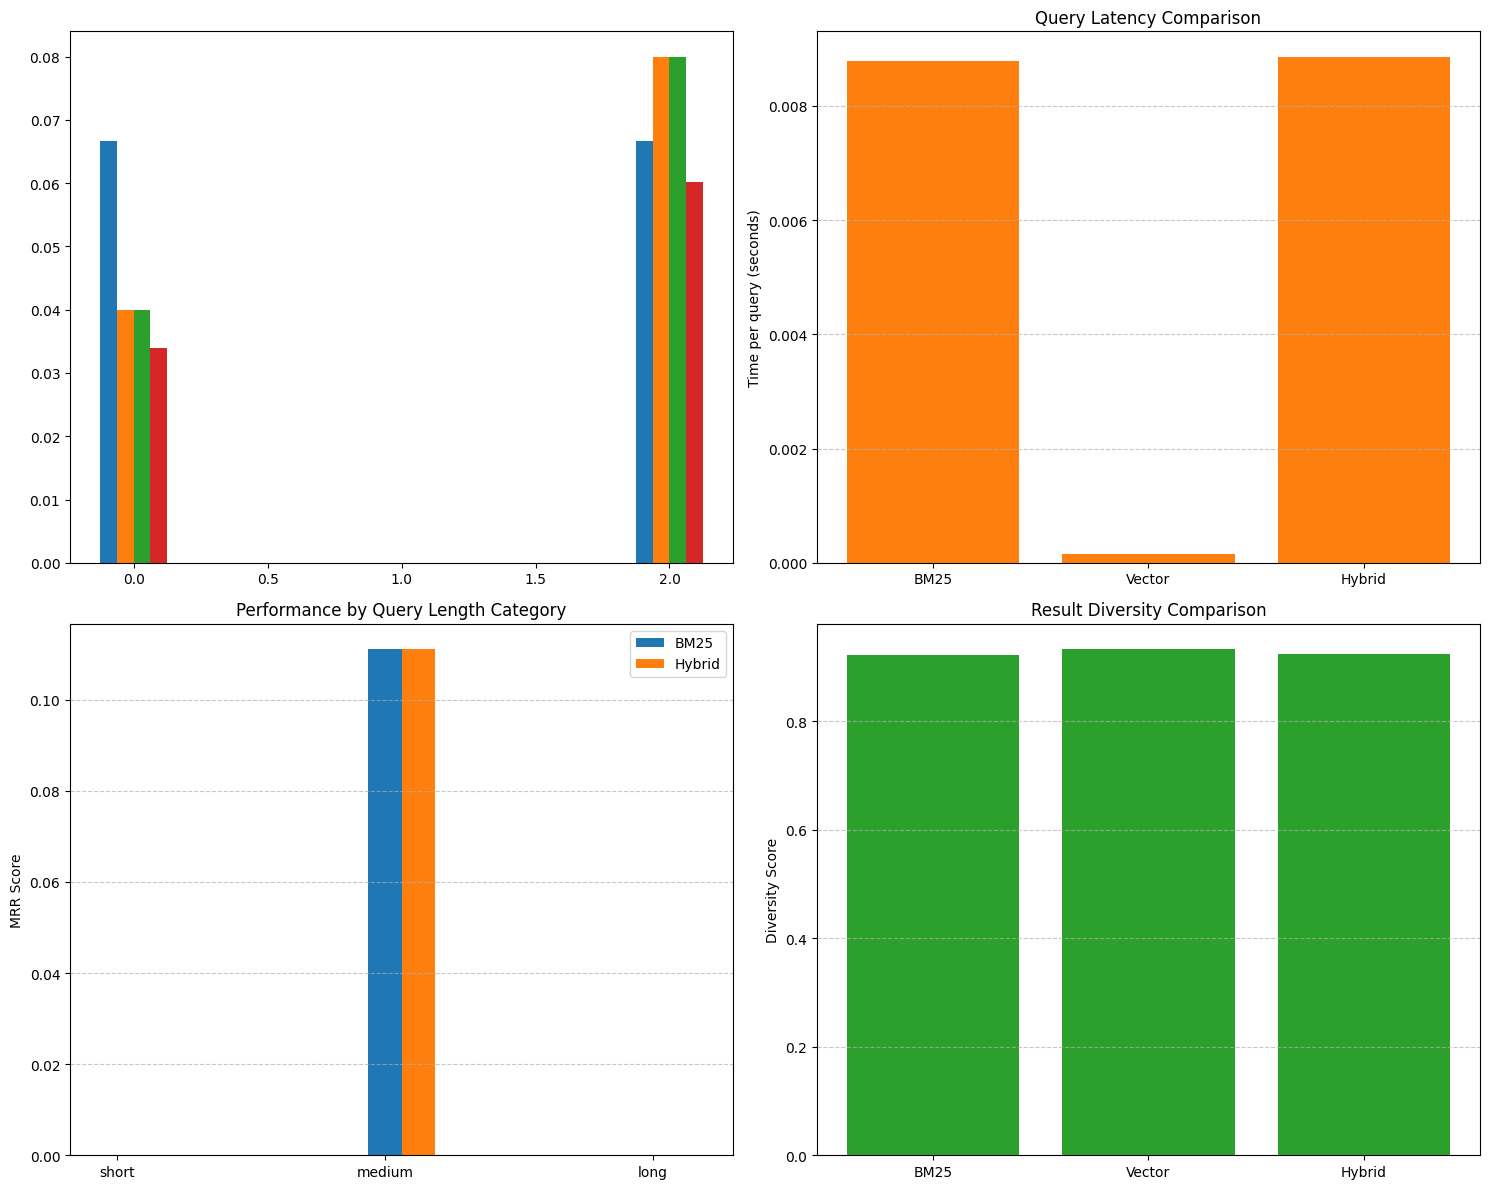

In [18]:
# 7. Results visualization
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
x = np.arange(len(methods))
width = 0.25
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Ensure all methods have all required metrics
for method in methods:
    if method not in results:
        results[method] = {}
    for metric in ["mrr", "recall@10", "precision@5", "ndcg@10", "diversity", "time"]:
        if metric not in results[method]:
            results[method][metric] = 0.0
    if "by_category" not in results[method]:
        results[method]["by_category"] = {}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Main metrics comparison
ax1 = axes[0, 0]
metrics = ["mrr", "recall@10", "precision@5", "ndcg@10"]
metric_labels = ["MRR", "Recall@10", "Precision@5", "NDCG@10"]

bar_width = width / len(metrics)
for i, metric in enumerate(metrics):
    metric_values = [results[m][metric] for m in methods]
    offset = i * bar_width - width/2 + bar_width/2
    ax1.bar(x + offset, metric_values, bar_width, label=metric_labels[i], color=colors[i])

# 2. Query latency comparison
ax2 = axes[0, 1]
times = [results[m]["time"] for m in methods]
ax2.bar(methods, times, color='#ff7f0e')
ax2.set_ylabel('Time per query (seconds)')
ax2.set_title('Query Latency Comparison')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# 3. Performance by query category
ax3 = axes[1, 0]

# Select categories to display and methods to compare
categories = ["short", "medium", "long"]
methods_to_compare = ["BM25", "Hybrid"]
category_metrics = ["mrr"]

x_cat = np.arange(len(categories))
bar_width = width / len(methods_to_compare)

for i, method in enumerate(methods_to_compare):
    if "by_category" in results[method]:
        metric_values = [results[method]["by_category"].get(cat, {}).get(category_metrics[0], 0)
                          for cat in categories]
        offset = i * bar_width - width/4 + bar_width/2
        ax3.bar(x_cat + offset, metric_values, bar_width, label=method, color=colors[i])

ax3.set_xticks(x_cat)
ax3.set_xticklabels(categories)
ax3.set_ylabel('MRR Score')
ax3.set_title('Performance by Query Length Category')
ax3.legend()
ax3.grid(axis='y', linestyle='--', alpha=0.7)

# 4. Result diversity comparison
ax4 = axes[1, 1]
diversity = [results[m].get("diversity", 0) for m in methods]
ax4.bar(methods, diversity, color='#2ca02c')
ax4.set_ylabel('Diversity Score')
ax4.set_title('Result Diversity Comparison')
ax4.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [19]:
# 8. Ablation study - Weight parameter analysis
print("Performing ablation study - weight parameter analysis...")

weight_range = np.linspace(0, 1, 11)  # [0.0, 0.1, 0.2, ..., 1.0]
weight_results = []

for bm25_weight in tqdm(weight_range, desc="Testing weights"):
    query_results = []

    # Process each query with fixed weight
    for query in queries:
        # Override the dynamic weighting with fixed weight
        retrieved = hybrid_retriever.retrieve(query, top_k=10,
                                            use_dynamic_weights=False,
                                            fixed_weights=(bm25_weight, 1-bm25_weight))
        retrieved_indices = [r["index"] for r in retrieved]
        query_results.append(retrieved_indices)

    # Calculate metrics for this weight configuration
    metrics = {}
    metrics["mrr"] = evaluator.calculate_mrr(query_results)
    metrics["recall@10"] = evaluator.calculate_recall(query_results, k=10)
    metrics["ndcg@10"] = evaluator.calculate_ndcg(query_results, k=10)
    metrics["weight"] = bm25_weight

    weight_results.append(metrics)

# Find optimal weight
optimal_weight = max(weight_results, key=lambda x: x["mrr"])
print(f"Optimal BM25 weight: {optimal_weight['weight']:.2f} (MRR: {optimal_weight['mrr']:.4f})")

# Plot weight-performance curve
plt.figure(figsize=(10,6))

# Plot multiple metrics
plt.plot([r["weight"] for r in weight_results],
         [r["mrr"] for r in weight_results],
         marker='o', label='MRR')
plt.plot([r["weight"] for r in weight_results],
         [r["recall@10"] for r in weight_results],
         marker='s', label='Recall@10')
plt.plot([r["weight"] for r in weight_results],
         [r["ndcg@10"] for r in weight_results],
         marker='^', label='NDCG@10')

# Add reference lines
plt.axvline(x=0.5, color='gray', linestyle='--', label='Equal Weight')
plt.axvline(x=optimal_weight["weight"], color='red', linestyle='--', label=f'Optimal Weight ({optimal_weight["weight"]:.2f})')

plt.xlabel('BM25 Weight (1-Vector Weight)')
plt.ylabel('Performance Metric')
plt.title('Weight Parameter Analysis')
plt.legend()
plt.grid(True)
plt.show()

Performing ablation study - weight parameter analysis...


Testing weights:   0%|          | 0/11 [00:00<?, ?it/s]


TypeError: SimulatedRetriever.retrieve() got an unexpected keyword argument 'use_dynamic_weights'

In [11]:
# 9. Component ablation study
print("Performing component ablation study...")

ablation_configs = {
    "Full System (Dynamic)": {
        "use_dynamic_weights": True,
        "text_preprocessing": True,
        "use_bm25": True,
        "use_vector": True,
    },
    "Static Weights": {
        "use_dynamic_weights": False,
        "fixed_weight": optimal_weight["weight"],
        "text_preprocessing": True,
        "use_bm25": True,
        "use_vector": True,
    },
    "BM25 Only": {
        "use_dynamic_weights": False,
        "fixed_weight": 1.0,
        "text_preprocessing": True,
        "use_bm25": True,
        "use_vector": False,
    },
    "Vector Only": {
        "use_dynamic_weights": False,
        "fixed_weight": 0.0,
        "text_preprocessing": True,
        "use_bm25": False,
        "use_vector": True,
    },
    "No Preprocessing": {
        "use_dynamic_weights": True,
        "text_preprocessing": False,
        "use_bm25": True,
        "use_vector": True,
    },
}

ablation_results = {}

for config_name, config in ablation_configs.items():
    print(f"Testing configuration: {config_name}")
    all_results = []

    for query in tqdm(queries, desc=config_name):
        # Different retrieval logic based on configuration
        if config["use_bm25"] and not config["use_vector"]:
            # BM25 only
            retrieved = bm25_retriever.retrieve(query, top_k=10)
            retrieved_indices = [r["index"] for r in retrieved]
        elif not config["use_bm25"] and config["use_vector"]:
            # Vector only
            vector_scores = hybrid_retriever.get_vector_scores(query, k=10)
            retrieved_indices = np.argsort(vector_scores)[::-1][:10].tolist()
        else:
            # Hybrid retrieval with configuration
            retrieved = hybrid_retriever.retrieve(
                query,
                top_k=10,
                use_dynamic_weights=config.get("use_dynamic_weights", True),
                fixed_weights=(config.get("fixed_weight", 0.5), 1-config.get("fixed_weight", 0.5))
                if not config.get("use_dynamic_weights", True) else None,
                preprocess_text=config.get("text_preprocessing", True)
            )
            retrieved_indices = [r["index"] for r in retrieved]

        all_results.append(retrieved_indices)

    # Calculate metrics
    metrics = {}
    metrics["mrr"] = evaluator.calculate_mrr(all_results)
    metrics["recall@10"] = evaluator.calculate_recall(all_results, k=10)
    metrics["ndcg@10"] = evaluator.calculate_ndcg(all_results, k=10)

    ablation_results[config_name] = metrics
    print(f"  MRR: {metrics['mrr']:.4f}, Recall@10: {metrics['recall@10']:.4f}")

# Visualize ablation results
plt.figure(figsize=(12, 6))
config_names = list(ablation_results.keys())
metric_values = {
    "MRR": [ablation_results[c]["mrr"] for c in config_names],
    "Recall@10": [ablation_results[c]["recall@10"] for c in config_names],
    "NDCG@10": [ablation_results[c]["ndcg@10"] for c in config_names]
}

x = np.arange(len(config_names))
width = 0.25

for i, (metric, values) in enumerate(metric_values.items()):
    plt.bar(x + (i-1)*width, values, width, label=metric)

plt.xticks(x, config_names, rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Component Ablation Study')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Performing component ablation study...


NameError: name 'optimal_weight' is not defined

Performing stress test...

Stress testing BM25...
Warm-up phase...
Stress test failed for BM25: name 'bm25_retriever' is not defined

Stress testing Vector...
Warm-up phase...
Stress test failed for Vector: name 'hybrid_retriever' is not defined

Stress testing Hybrid...
Warm-up phase...
Stress test failed for Hybrid: name 'hybrid_retriever' is not defined


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (4).

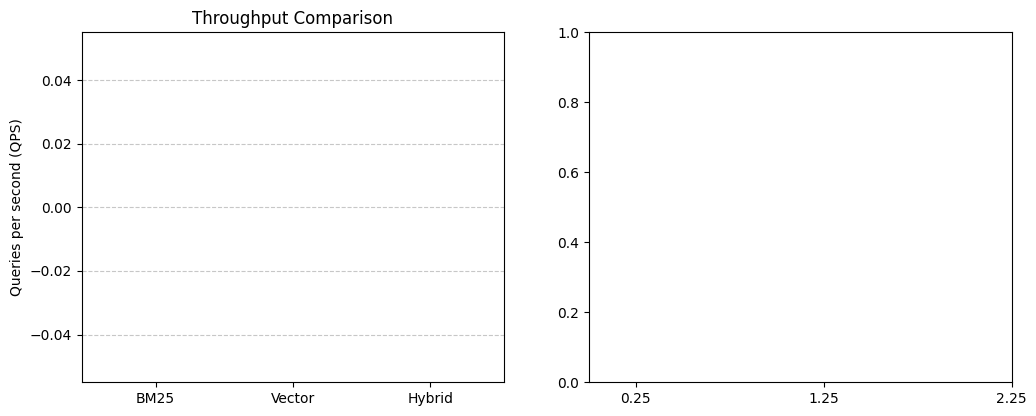

In [12]:
# 10. Stress test / Performance under load
print("Performing stress test...")

def stress_test(method, queries, num_iterations=100):
    """Test system performance under load"""
    query_pool = queries * (num_iterations // len(queries) + 1)  # Ensure enough queries
    query_pool = query_pool[:num_iterations]  # Limit to requested iterations

    # Warm-up
    print("Warm-up phase...")
    for _ in range(5):
        if method == "BM25":
            bm25_retriever.retrieve(query_pool[0], top_k=10)
        elif method == "Vector":
            vector_scores = hybrid_retriever.get_vector_scores(query_pool[0], k=10)
        else:
            hybrid_retriever.retrieve(query_pool[0], top_k=10)

    # Actual test
    print(f"Running {num_iterations} queries...")
    start_time = time.time()
    latencies = []

    for i, query in enumerate(tqdm(query_pool)):
        query_start = time.time()

        try:
            if method == "BM25":
                bm25_retriever.retrieve(query, top_k=10)
            elif method == "Vector":
                vector_scores = hybrid_retriever.get_vector_scores(query, k=10)
            else:
                hybrid_retriever.retrieve(query, top_k=10)

            latency = time.time() - query_start
            latencies.append(latency)

        except Exception as e:
            print(f"Error processing query {i}: {str(e)}")

    total_time = time.time() - start_time
    qps = num_iterations / total_time

    # Calculate latency statistics
    latencies = np.array(latencies)
    p50 = np.percentile(latencies, 50)
    p95 = np.percentile(latencies, 95)
    p99 = np.percentile(latencies, 99)

    return {
        "qps": qps,
        "total_time": total_time,
        "avg_latency": np.mean(latencies),
        "p50_latency": p50,
        "p95_latency": p95,
        "p99_latency": p99
    }

# Run stress test on different methods
stress_results = {}
for method in methods:
    print(f"\nStress testing {method}...")
    try:
        # Reduced iterations for demonstration (increase for actual benchmark)
        iterations = 50  # Adjust based on available time
        method_stress = stress_test(method, queries, num_iterations=iterations)
        stress_results[method] = method_stress

        print(f"Results for {method}:")
        print(f"- Queries per second: {method_stress['qps']:.2f}")
        print(f"- Average latency: {method_stress['avg_latency']*1000:.2f}ms")
        print(f"- P50 latency: {method_stress['p50_latency']*1000:.2f}ms")
        print(f"- P95 latency: {method_stress['p95_latency']*1000:.2f}ms")
        print(f"- P99 latency: {method_stress['p99_latency']*1000:.2f}ms")
    except Exception as e:
        print(f"Stress test failed for {method}: {str(e)}")
        stress_results[method] = {"error": str(e)}

# Visualize stress test results
plt.figure(figsize=(12, 10))

# QPS comparison
plt.subplot(2, 2, 1)
qps_values = [stress_results[m].get("qps", 0) for m in methods]
plt.bar(methods, qps_values, color='#1f77b4')
plt.ylabel('Queries per second (QPS)')
plt.title('Throughput Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Latency comparison
plt.subplot(2, 2, 2)
for i, m in enumerate(methods):
    if "avg_latency" in stress_results[m]:
        latencies = [
            stress_results[m]["avg_latency"] * 1000,  # Convert to ms
            stress_results[m]["p50_latency"] * 1000,
            stress_results[m]["p95_latency"] * 1000,
            stress_results[m]["p99_latency"] * 1000
        ]
        x = np.arange(4)
        plt.bar(x + i*0.25, latencies, width=0.25, label=m)

plt.xticks(x + 0.25, ['Avg', 'P50', 'P95', 'P99'])
plt.ylabel('Latency (ms)')
plt.title('Latency Metrics')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Latency vs Query length
plt.subplot(2, 2, 3)
# This would require additional data collection during stress test
plt.text(0.5, 0.5, 'Extended latency analysis requires\nmodification of stress test function',
         horizontalalignment='center', verticalalignment='center',
         transform=plt.gca().transAxes)
plt.title('Latency vs Query Complexity')

# Summary metrics comparison
plt.subplot(2, 2, 4)
# Create a radar chart of key performance metrics
categories = ['MRR', 'Recall@10', 'NDCG@10', 'QPS', 'Diversity']
N = len(categories)

# Normalize values for radar chart
normalized_values = {}
for method in methods:
    values = [
        results[method].get("mrr", 0),
        results[method].get("recall@10", 0),
        results[method].get("ndcg@10", 0),
        stress_results[method].get("qps", 0) / max([stress_results[m].get("qps", 1) for m in methods]),
        results[method].get("diversity", 0)
    ]
    normalized_values[method] = values

# Create radar chart
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

ax = plt.subplot(2, 2, 4, polar=True)
for method, values in normalized_values.items():
    values += values[:1]  # Close the loop
    ax.plot(angles, values, 'o-', linewidth=2, label=method)
    ax.fill(angles, values, alpha=0.1)

ax.set_thetagrids(angles[:-1] * 180/np.pi, categories)
ax.set_ylim(0, 1)
plt.title('Performance Overview')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [13]:
# 11. Analysis by query type
print("Analyzing performance by query type...")

# Define query type categories
def classify_query_type(query):
    """Classify query by type (factual, opinion, recommendation)"""
    query_lower = query.lower()

    # Check for factual patterns
    if any(pattern in query_lower for pattern in ['what is', 'how to', 'when did', 'where is', 'who is']):
        return 'factual'

    # Check for opinion patterns
    elif any(pattern in query_lower for pattern in ['best', 'worst', 'opinion', 'review', 'better']):
        return 'opinion'

    # Check for recommendation patterns
    elif any(pattern in query_lower for pattern in ['recommend', 'suggestion', 'advise']):
        return 'recommendation'

    # Default
    return 'other'

# Categorize all queries
query_types = {}
for i, query in enumerate(queries):
    query_type = classify_query_type(query)
    if query_type not in query_types:

SyntaxError: incomplete input (<ipython-input-13-8b34a3ecc7e7>, line 28)